In [1]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV

def construct_clf(clf_name):
    clf = None
    if clf_name == 'SVM':
        clf = svm.LinearSVC()
    elif clf_name == 'DTree' :
        clf = DecisionTreeClassifier(max_depth=10, class_weight='balanced')
    elif clf_name == 'NB' :
        clf = BernoulliNB()
    clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正
    return clf

In [2]:
class Bagging(object):
    def __init__(self, clf, num_iter):
        self.clf = clf  # 分类器对象
        self.num_iter = num_iter  # Bagging 的分类器个数
        
    def fit_predict(self, X, Y, test_X):
#         X = X.values
#         Y = Y.values
#         test_X = test_X.values
        result = np.zeros(test_X.shape[0])  # 记录测试集的预测结果
        train_idx = np.arange(len(Y))
        for i in range(self.num_iter):
            sample_idx = np.random.choice(train_idx, size=len(Y), replace=True)  # Bootstrap
            sample_train_X = X[sample_idx]
            sample_train_Y = Y[sample_idx]
            self.clf.fit(sample_train_X, sample_train_Y)
#             print('Model {:>2d} finish!'.format(i))
            predict_proba = self.clf.predict_proba(test_X)[:, 1]
            result += predict_proba  # 累加不同分类器的预测概率
        result /= self.num_iter  # 取平均（投票）
        return result

In [3]:
class AdaBoostM1(object):
    def __init__(self, clf, num_iter):
        self.clf = clf  # 分类器对象
        self.num_iter = num_iter  # 迭代次数
        
    def fit_predict(self, X, Y, test_X):
#         X = X.values
#         Y = Y.values
#         test_X = test_X.values
        result_lst, beta_lst = list(), list()  # 记录每次迭代的预测结果和投票权重
        num_samples = len(Y)
        weight = np.ones(num_samples)  # 样本权重，注意总和应为 num_samples
        for i in range(self.num_iter):
            self.clf.fit(X, Y, sample_weight=weight)  # 带权重的 fit
#             print('Model {:<2d} finish!'.format(i))
            train_predict = self.clf.predict(X)  # 训练集预测结果
            error_flag = train_predict != Y  # 预测错误的位置
            error = weight[error_flag].sum() / num_samples  # 计算错误率
            if error > 0.5:
                break
            beta = error / (1 - error)
            weight *= (1.0 - error_flag) * beta + error_flag  # 调整权重，正确位置乘上 beta，错误位置还是原来的
            weight /= weight.sum() / num_samples  # 归一化，让权重和等于 num_samples
            beta_lst.append(beta)
            predict_proba = self.clf.predict_proba(test_X)[:, 1]
            result_lst.append(predict_proba)
#             pre = self.clf.predict(test_X)
#             result_lst.append(pre)
        beta_lst = np.log(1 / np.array(beta_lst))
        beta_lst /= beta_lst.sum()  # 归一化投票权重
#         print('\nVote Weight:\n', beta_lst)
        result = (np.array(result_lst) * beta_lst[:, None]).sum(0)  # 每一轮的预测结果加权求和
        return result

In [4]:
from sklearn.metrics import roc_auc_score

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
clf = construct_clf('DTree')

In [7]:
clf_svm = AdaBoostM1(clf,10)

In [9]:
# 使用sklearn生成二分类数据集
from sklearn.datasets import make_classification

In [22]:
x, y = make_classification(n_samples=10000, n_features=10, n_informative=2, 
                           n_redundant=2, n_classes=2, n_clusters_per_class=2,
                          flip_y=0.01, class_sep=1.0, scale=1.0)

In [23]:
y.shape

(10000,)

In [24]:
x.shape

(10000, 10)

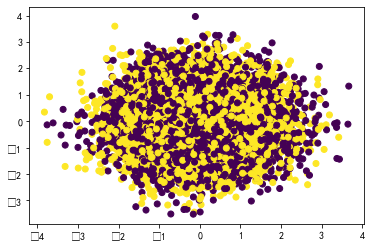

In [26]:
import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], c=y)